# ML Results Visualization

Visualization notebook for ML batch evaluation results stored in S3 machine-learning structure.

S3 Structure: {save_result_path}/machine-learning/{experiment_type}/{model_name}/
├── results.pkl            # Full evaluation results DataFrame
├── summary-stats.csv      # Aggregated statistics
├── run-metadata.yml       # Run configuration and metadata
└── failed-tasks.csv       # Tasks that failed during processing (if any)

## Configuration

In [46]:
# Configuration variables - simplified for one model and one experiment
EXPERIMENT_TYPE = "parameter-distortion-v2"  # Single experiment type
MODEL_NAME = "sy_simple"  # Single model name

# Experiment type mapping to perturbation column names
PERTURBATION_MAPPING = {
    "expression-noise-v1": "Expression Noise Level",
    "parameter-distortion-v2": "Distortion Factor", 
    "response-noise-v1": "Response Noise Level"
}

# Perturbation level configurations
PERTURBATION_LEVELS = {
    "expression-noise-v1": [0.0, 0.1, 0.2, 0.3, 0.5, 1.0],
    "response-noise-v1": [0.0, 0.1, 0.2, 0.3, 0.5, 1.0],
    "parameter-distortion-v2": [0, 0.1, 0.5],
}

# Common level patterns for detection in feature labels
LEVEL_PATTERNS = {
    "noise": ["noise_{level}", "_{level}"],
    "distortion": ["distortion_{level}", "_{level}"]
}

# Visualization settings
PLOT_STYLE = "whitegrid"
FONT_SCALE = 1.2
FIGURE_SIZE = (10, 4)

## Initialization

In [47]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Optional, Any, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set up project path - same pattern as robustness notebooks
path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"✅ Project path set to: {os.getcwd()}")

# Set up plotting style
sns.set_style(PLOT_STYLE)
sns.set_context("talk", font_scale=FONT_SCALE)

# Import S3ConfigManager
from models.utils.s3_config_manager import S3ConfigManager

# Initialize S3 manager
s3_manager = S3ConfigManager()
print(f"✅ S3 connection established. Save result path: {s3_manager.save_result_path}")

✅ Project path set to: c:\Github\new-peak-project\src
✅ S3 connection successful. Bucket: bio-data
✅ S3 connection established. Save result path: new-peak-project/experiments/ch5-paper


## Data Loading Functions

In [48]:
def load_ml_results(experiment_type: str, model_name: str) -> Optional[pd.DataFrame]:
    """
    Load ML results from S3 for a specific experiment and model.
    
    Args:
        experiment_type: Type of experiment (e.g., "expression_noise_v1")
        model_name: Name of the model (e.g., "sy_simple")
        
    Returns:
        DataFrame with results or None if loading fails
    """
    base_path = f"{s3_manager.save_result_path}/machine-learning"
    results_path = f"{base_path}/{experiment_type}/{model_name}/results.pkl"
    
    try:
        results_df = s3_manager.load_data_from_path(results_path, data_format="pkl")
        print(f"✅ Loaded results: {experiment_type}/{model_name} ({len(results_df)} rows)")
        
        # Add experiment type and model name if not present
        if "experiment_type" not in results_df.columns:
            results_df["experiment_type"] = experiment_type
        if "model_name" not in results_df.columns:
            results_df["model_name"] = model_name
            
        return results_df
    except Exception as e:
        print(f"❌ Error loading results for {experiment_type}/{model_name}: {e}")
        return None

def clean_feature_label(feature_label: str) -> str:
    """
    Clean feature label by removing noise/distortion level suffixes.
    
    Examples:
    - "dynamic_features_0" → "dynamic_features"
    - "dynamic_features no outcome_0.1" → "dynamic_features"
    - "static_features_1.1" → "static_features"
    - "noisy_features_0.2" → "noisy_features"
    """
    import re
    
    label = str(feature_label)
    
    # Remove trailing numbers with underscores (e.g., _0, _0.1, _1.1)
    label = re.sub(r'_\d+(\.\d+)?$', '', label)
    
    # Remove " no outcome" suffix if present
    label = label.replace(" no outcome", "")
    
    # Remove trailing whitespace
    label = label.strip()
    
    # Common feature type mappings
    feature_type_mapping = {
        "dynamic_features": "Dynamic Features",
        "static_features": "Static Features",
        "noisy_features": "Noisy Features",
        "original_features": "Original Features",
        "features": "Features"
    }
    
    # Map to standardized names
    for key, value in feature_type_mapping.items():
        if key in label.lower():
            return value
    
    return label

def detect_perturbation_level(label: str, experiment_type: str) -> Optional[float]:
    """
    Detect perturbation level from feature label using configuration-based approach.
    
    Args:
        label: Feature label string
        experiment_type: Type of experiment (e.g., "expression-noise-v1")
        
    Returns:
        Detected perturbation level as float, or None if not found
    """
    import re
    
    label_lower = label.lower()
    normalized_experiment_type = experiment_type.replace('-', '_')
    
    # Get configured levels for this experiment type
    configured_levels = PERTURBATION_LEVELS.get(experiment_type, [])
    
    # Method 1: Try to match exact configured levels first
    for level in configured_levels:
        # Check for common patterns
        patterns = [
            f"_{level}",
            f"noise_{level}",
            f"distortion_{level}",
            f"_{level}_",
        ]
        
        for pattern in patterns:
            if pattern in label_lower:
                return float(level)
    
    # Method 2: Extract all numbers from label and try to match
    numbers = re.findall(r'(\d+(?:\.\d+)?)', label)
    if numbers:
        nums = [float(n) for n in numbers]
        
        # For noise experiments, look for numbers in configured levels
        if normalized_experiment_type in ["expression_noise_v1", "response_noise_v1"]:
            for num in nums:
                # Check if this number is close to any configured level
                for level in configured_levels:
                    if abs(num - level) < 0.001:
                        return float(level)
            
            # If no exact match, use the smallest positive number
            positive_nums = [n for n in nums if n >= 0]
            if positive_nums:
                return float(min(positive_nums))
        
        # For distortion experiments, look for numbers >= 1.0
        elif normalized_experiment_type == "parameter_distortion_v2":
            distortion_nums = [n for n in nums if n >= 1.0]
            if distortion_nums:
                # Try to match configured distortion factors
                for num in distortion_nums:
                    for level in configured_levels:
                        if abs(num - level) < 0.001:
                            return float(level)
                
                # If no exact match, use the smallest distortion number
                return float(min(distortion_nums))
    
    # Method 3: Fallback to regex pattern matching for common cases
    # This handles edge cases not covered by configuration
    if "noise_0" in label_lower or "_0" in label_lower:
        return 0.0
    elif any(f"_0.{i}" in label_lower for i in [1, 2, 3, 5]):
        for i in [1, 2, 3, 5]:
            if f"_0.{i}" in label_lower or f"noise_0.{i}" in label_lower:
                return float(f"0.{i}")
    elif "_1.0" in label_lower or "noise_1.0" in label_lower:
        return 1.0
    elif any(f"_1.{i}" in label_lower for i in [1, 3, 5]):
        for i in [1, 3, 5]:
            if f"_1.{i}" in label_lower or f"distortion_1.{i}" in label_lower:
                return float(f"1.{i}")
    elif "_2.0" in label_lower or "distortion_2.0" in label_lower:
        return 2.0
    elif "_3.0" in label_lower or "distortion_3.0" in label_lower:
        return 3.0
    
    return None

def extract_perturbation_level_and_feature_type(results_df: pd.DataFrame, experiment_type: str) -> pd.DataFrame:
    """
    Extract perturbation level and clean feature type from feature data labels.
    
    Args:
        results_df: Results DataFrame
        experiment_type: Type of experiment
        
    Returns:
        DataFrame with added 'perturbation_level' and 'feature_type' columns
    """
    df = results_df.copy()
    
    perturbation_levels = []
    feature_types = []
    
    for idx, feature_label in enumerate(df["Feature Data"]):
        label = str(feature_label)
        
        # Debug: Show first few labels to understand format
        if idx < 3:
            print(f"  Sample label {idx}: '{label}'")
        
        # Use the new configuration-based detection function
        level = detect_perturbation_level(label, experiment_type)
        
        # Clean feature type
        feature_type = clean_feature_label(label)
        
        perturbation_levels.append(level)
        feature_types.append(feature_type)
    
    df["perturbation_level"] = perturbation_levels
    df["feature_type"] = feature_types
    
    # Set appropriate column name based on experiment type (uses original type for mapping)
    if experiment_type in PERTURBATION_MAPPING:
        df[PERTURBATION_MAPPING[experiment_type]] = df["perturbation_level"]
    
    return df

def load_and_prepare_data() -> Optional[pd.DataFrame]:
    """
    Load and prepare data for visualization.
    
    Returns:
        Prepared DataFrame or None if loading fails
    """
    print(f"📊 Loading data for experiment: {EXPERIMENT_TYPE}, model: {MODEL_NAME}")
    
    # Load results
    results_df = load_ml_results(EXPERIMENT_TYPE, MODEL_NAME)
    if results_df is None:
        return None
    
    # Extract perturbation levels and feature types
    prepared_df = extract_perturbation_level_and_feature_type(results_df, EXPERIMENT_TYPE)
    
    # Check if we successfully extracted perturbation levels
    if prepared_df["perturbation_level"].isna().all():
        print(f"⚠️ Could not extract perturbation levels from feature labels")
        print(f"   Feature Data labels: {prepared_df['Feature Data'].unique()[:5]}")
        # Return data without perturbation levels
        return prepared_df
    else:
        # Remove rows where perturbation level couldn't be determined
        valid_df = prepared_df.dropna(subset=["perturbation_level"])
        print(f"✅ Extracted perturbation levels: {sorted(valid_df['perturbation_level'].unique())}")
        print(f"✅ Feature types: {valid_df['feature_type'].unique()}")
        return valid_df

## Load Data

In [49]:
# Load and prepare data
data_df = load_and_prepare_data()

if data_df is None:
    print("❌ Failed to load data. Please check:")
    print(f"   1. Experiment type: {EXPERIMENT_TYPE}")
    print(f"   2. Model name: {MODEL_NAME}")
    print(f"   3. S3 path: {s3_manager.save_result_path}/machine-learning/{EXPERIMENT_TYPE}/{MODEL_NAME}/results.pkl")
    # Create empty DataFrame for fallback
    data_df = pd.DataFrame()
else:
    print(f"\n📋 Data Summary:")
    print(f"   Total rows: {len(data_df)}")
    print(f"   Columns: {list(data_df.columns)}")
    if "perturbation_level" in data_df.columns:
        print(f"   Perturbation levels: {sorted(data_df['perturbation_level'].unique())}")
    print(f"   Models: {data_df['Model'].unique()}")
    print(f"   Feature Data types: {data_df['Feature Data'].nunique()} unique")
    
    # Show first few rows
    print("\n📄 Data preview:")
    print(data_df.head())

📊 Loading data for experiment: parameter-distortion-v2, model: sy_simple


✅ Loaded results: parameter-distortion-v2/sy_simple (750 rows)
  Sample label 0: 'features_0'
  Sample label 1: 'features_0'
  Sample label 2: 'features_0'
✅ Extracted perturbation levels: [np.float64(0.0)]
✅ Feature types: ['Features' 'Dynamic Features' 'last_time_points'
 'last_time_points_no_outcome']

📋 Data Summary:
   Total rows: 750
   Columns: ['Model', 'Feature Data', 'Mean Squared Error', 'R2 Score', 'Pearson Correlation', 'Pearson P-Value', 'experiment_type', 'model_name', 'evaluation_timestamp', 'perturbation_level', 'feature_type', 'Distortion Factor']
   Perturbation levels: [np.float64(0.0)]
   Models: ['Linear Regression' 'Random Forest' 'Gradient Boosting'
 'Support Vector Machine' 'Neural Network']
   Feature Data types: 15 unique

📄 Data preview:
               Model Feature Data  Mean Squared Error  R2 Score  \
0  Linear Regression   features_0        15293.061308 -0.014293   
1  Linear Regression   features_0        14999.134040 -0.000655   
2  Linear Regression   

In [62]:
data_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,experiment_type,model_name,evaluation_timestamp,perturbation_level,feature_type,Distortion Factor
0,Linear Regression,features_0,15293.061308,-0.014293,-0.046625,0.355982,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,Features,0.0
1,Linear Regression,features_0,14999.134040,-0.000655,0.057129,0.257931,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,Features,0.0
2,Linear Regression,features_0,15021.447615,0.002730,0.055062,0.275583,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,Features,0.0
3,Linear Regression,features_0,15713.272869,-0.002833,0.021508,0.670392,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,Features,0.0
4,Linear Regression,features_0,15983.074063,-0.037006,-0.121328,0.015972,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,Features,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
745,Neural Network,last_time_points_no_outcome_0.5,133912.072440,-7.616255,-0.013822,0.784472,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,last_time_points_no_outcome,0.0
746,Neural Network,last_time_points_no_outcome_0.5,18356.316607,-0.214267,0.078087,0.121762,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,last_time_points_no_outcome,0.0
747,Neural Network,last_time_points_no_outcome_0.5,29022.211712,-0.945927,-0.030737,0.542975,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,last_time_points_no_outcome,0.0
748,Neural Network,last_time_points_no_outcome_0.5,18193.416898,-0.174671,0.123452,0.014204,parameter-distortion-v2,sy_simple,2026-01-01T09:10:31.906626,0.0,last_time_points_no_outcome,0.0


## Visualizations

Each plot is defined and displayed in its own code block for better organization and individual execution.

### 1. Performance vs Perturbation Level

📈 Plot 1: Performance vs Perturbation Level


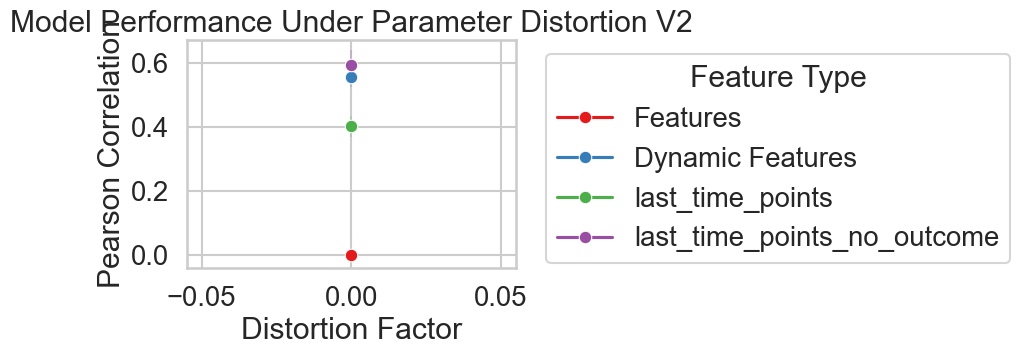

In [50]:
def plot_performance_vs_perturbation(data_df: pd.DataFrame, metric: str = "Pearson Correlation"):
    """
    Plot performance metric vs perturbation level (line plot).
    
    Adapted from robustness notebooks line plots.
    """
    if data_df.empty:
        print("❌ No data to plot")
        return
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    plt.figure(figsize=FIGURE_SIZE)
    
    # Create line plot using cleaned feature types
    if 'feature_type' in data_df.columns:
        hue_col = 'feature_type'
        legend_title = 'Feature Type'
    else:
        hue_col = 'Feature Data'
        legend_title = 'Feature Data Type'
    
    sns.lineplot(data=data_df, x=perturbation_col, y=metric, 
                 hue=hue_col, palette='Set1', marker='o', ci=95)
    
    # Customize plot
    title_suffix = EXPERIMENT_TYPE.replace('-', ' ').title()
    plt.title(f'Model Performance Under {title_suffix}')
    plt.xlabel(perturbation_col.replace('_', ' ').title())
    plt.ylabel(metric)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set x-axis ticks for expression noise to show all levels (0, 0.1, 0.2, 0.3, 0.5, 1.0)
    # Normalize experiment type for comparison
    normalized_experiment_type = EXPERIMENT_TYPE.replace('-', '_')
    if normalized_experiment_type == "expression_noise_v1" and perturbation_col in data_df.columns:
        # Get actual unique levels in data
        unique_levels = sorted(data_df[perturbation_col].unique())
        if unique_levels:
            plt.xticks(unique_levels)
    
    plt.tight_layout()
    plt.show()

# Display the plot
if not data_df.empty:
    print("📈 Plot 1: Performance vs Perturbation Level")
    plot_performance_vs_perturbation(data_df, metric="Pearson Correlation")
else:
    print("⚠️ No data available for visualization")

### 2. Zoomed View (Lower Perturbation Levels)

📈 Plot 2: Zoomed View (Lower Perturbation Levels)


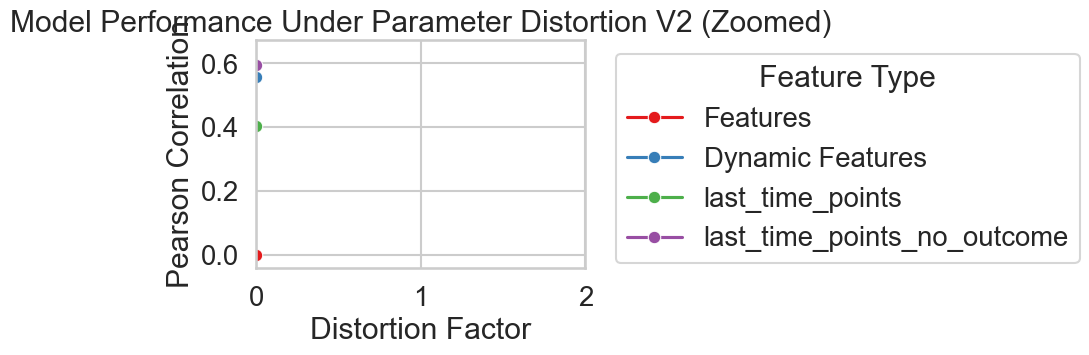

In [51]:
def plot_zoomed_performance(data_df: pd.DataFrame, metric: str = "Pearson Correlation", max_level: float = None):
    """
    Plot zoomed view for lower perturbation levels.
    
    Adapted from robustness notebooks zoomed views.
    """
    if data_df.empty:
        print("❌ No data to plot")
        return
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    # Normalize experiment type for comparison
    normalized_experiment_type = EXPERIMENT_TYPE.replace('-', '_')
    
    # Set default max level based on experiment type
    if max_level is None:
        if normalized_experiment_type == "expression_noise_v1":
            # For expression noise, use the maximum noise level in the data
            max_level = data_df[perturbation_col].max()
        elif normalized_experiment_type == "parameter_distortion_v2":
            max_level = 2.0
        elif normalized_experiment_type == "response_noise_v1":
            max_level = 0.3
        else:
            max_level = data_df[perturbation_col].max() * 0.5
    
    # Filter data for zoomed view
    filtered_data = data_df[data_df[perturbation_col] <= max_level]
    
    if filtered_data.empty:
        print(f"⚠️ No data below {max_level} for zoomed view")
        return
    
    plt.figure(figsize=FIGURE_SIZE)
    
    # Create line plot using cleaned feature types
    if 'feature_type' in filtered_data.columns:
        hue_col = 'feature_type'
        legend_title = 'Feature Type'
    else:
        hue_col = 'Feature Data'
        legend_title = 'Feature Data Type'
    
    sns.lineplot(data=filtered_data, x=perturbation_col, y=metric, 
                 hue=hue_col, palette='Set1', marker='o', ci=95)
    
    # Customize plot
    title_suffix = EXPERIMENT_TYPE.replace('-', ' ').title()
    plt.title(f'Model Performance Under {title_suffix} (Zoomed)')
    plt.xlabel(perturbation_col.replace('_', ' ').title())
    plt.ylabel(metric)
    plt.xlim(0, max_level)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Display the plot
if not data_df.empty:
    print("📈 Plot 2: Zoomed View (Lower Perturbation Levels)")
    plot_zoomed_performance(data_df, metric="Pearson Correlation")
else:
    print("⚠️ No data available for visualization")

### 3. Model Comparison

📈 Plot 3: Model Comparison


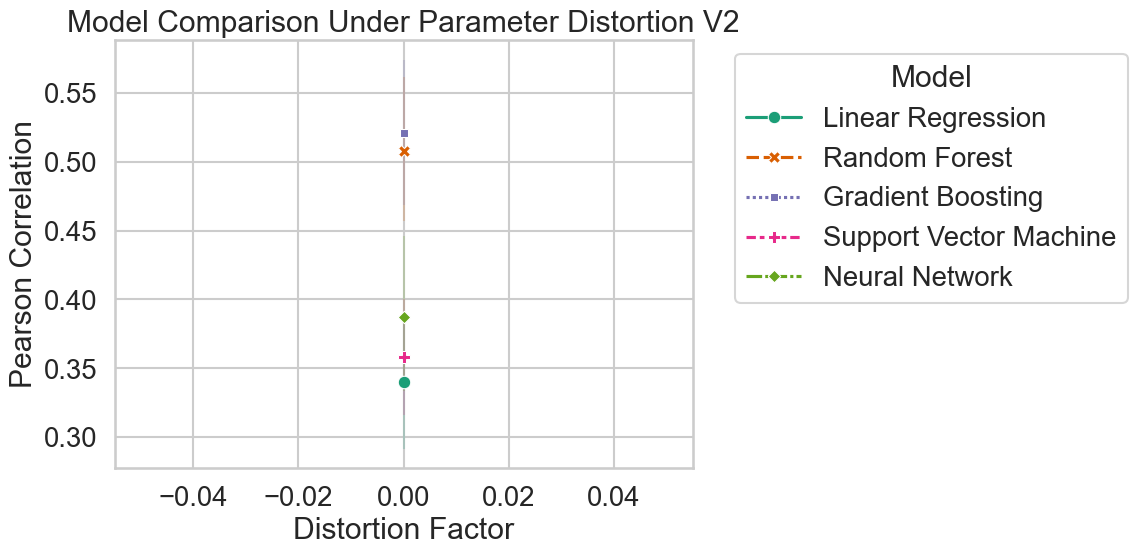

In [52]:
def plot_model_comparison(data_df: pd.DataFrame, metric: str = "Pearson Correlation"):
    """
    Plot model comparison across perturbation levels.
    
    Adapted from robustness notebooks model comparison plots.
    """
    if data_df.empty:
        print("❌ No data to plot")
        return
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    plt.figure(figsize=(12, 6))
    
    # Create line plot with model comparison
    sns.lineplot(data=data_df, x=perturbation_col, y=metric, 
                 hue='Model', style='Model', palette='Dark2', markers=True, ci=95)
    
    # Customize plot
    title_suffix = EXPERIMENT_TYPE.replace('-', ' ').title()
    plt.title(f'Model Comparison Under {title_suffix}')
    plt.xlabel(perturbation_col.replace('_', ' ').title())
    plt.ylabel(metric)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Display the plot
if not data_df.empty:
    print("📈 Plot 3: Model Comparison")
    plot_model_comparison(data_df, metric="Pearson Correlation")
else:
    print("⚠️ No data available for visualization")

### 4. Performance Distribution

📈 Plot 4: Performance Distribution


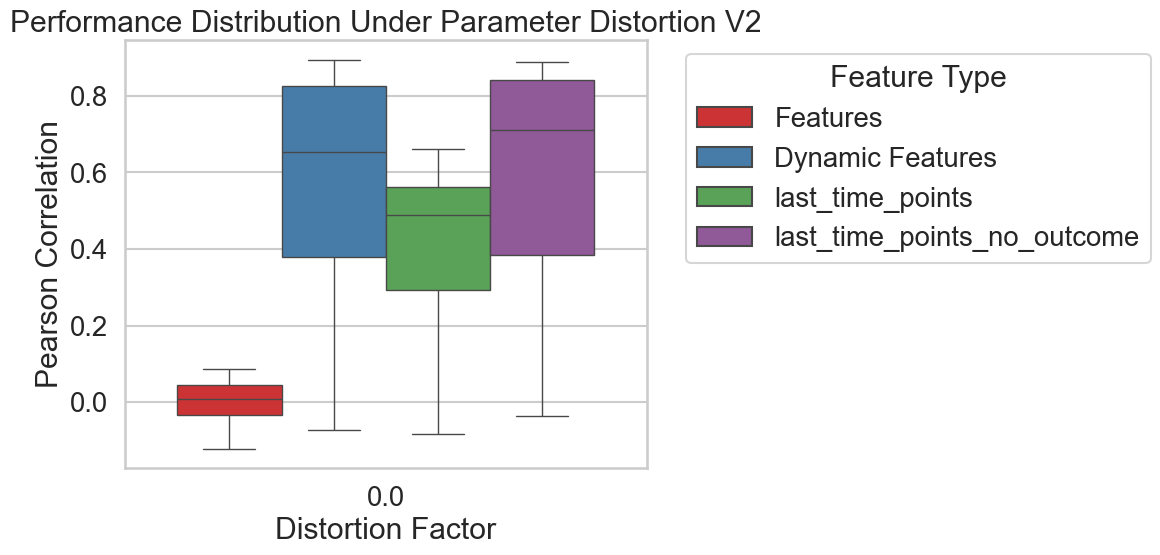

In [53]:
def plot_performance_distribution(data_df: pd.DataFrame, metric: str = "Pearson Correlation"):
    """
    Plot performance distribution using boxplots.
    
    Adapted from robustness notebooks boxplots.
    """
    if data_df.empty:
        print("❌ No data to plot")
        return
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    plt.figure(figsize=(12, 6))
    
    # Create boxplot using cleaned feature types
    if 'feature_type' in data_df.columns:
        hue_col = 'feature_type'
        legend_title = 'Feature Type'
    else:
        hue_col = 'Feature Data'
        legend_title = 'Feature Data Type'
    
    sns.boxplot(data=data_df, x=perturbation_col, y=metric, 
                hue=hue_col, palette='Set1')
    
    # Customize plot
    title_suffix = EXPERIMENT_TYPE.replace('-', ' ').title()
    plt.title(f'Performance Distribution Under {title_suffix}')
    plt.xlabel(perturbation_col.replace('_', ' ').title())
    plt.ylabel(metric)
    plt.legend(title=legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Display the plot
if not data_df.empty:
    print("📈 Plot 4: Performance Distribution")
    plot_performance_distribution(data_df, metric="Pearson Correlation")
else:
    print("⚠️ No data available for visualization")

### 5. Model-Specific Analysis

📈 Plot 5: Model-Specific Analysis


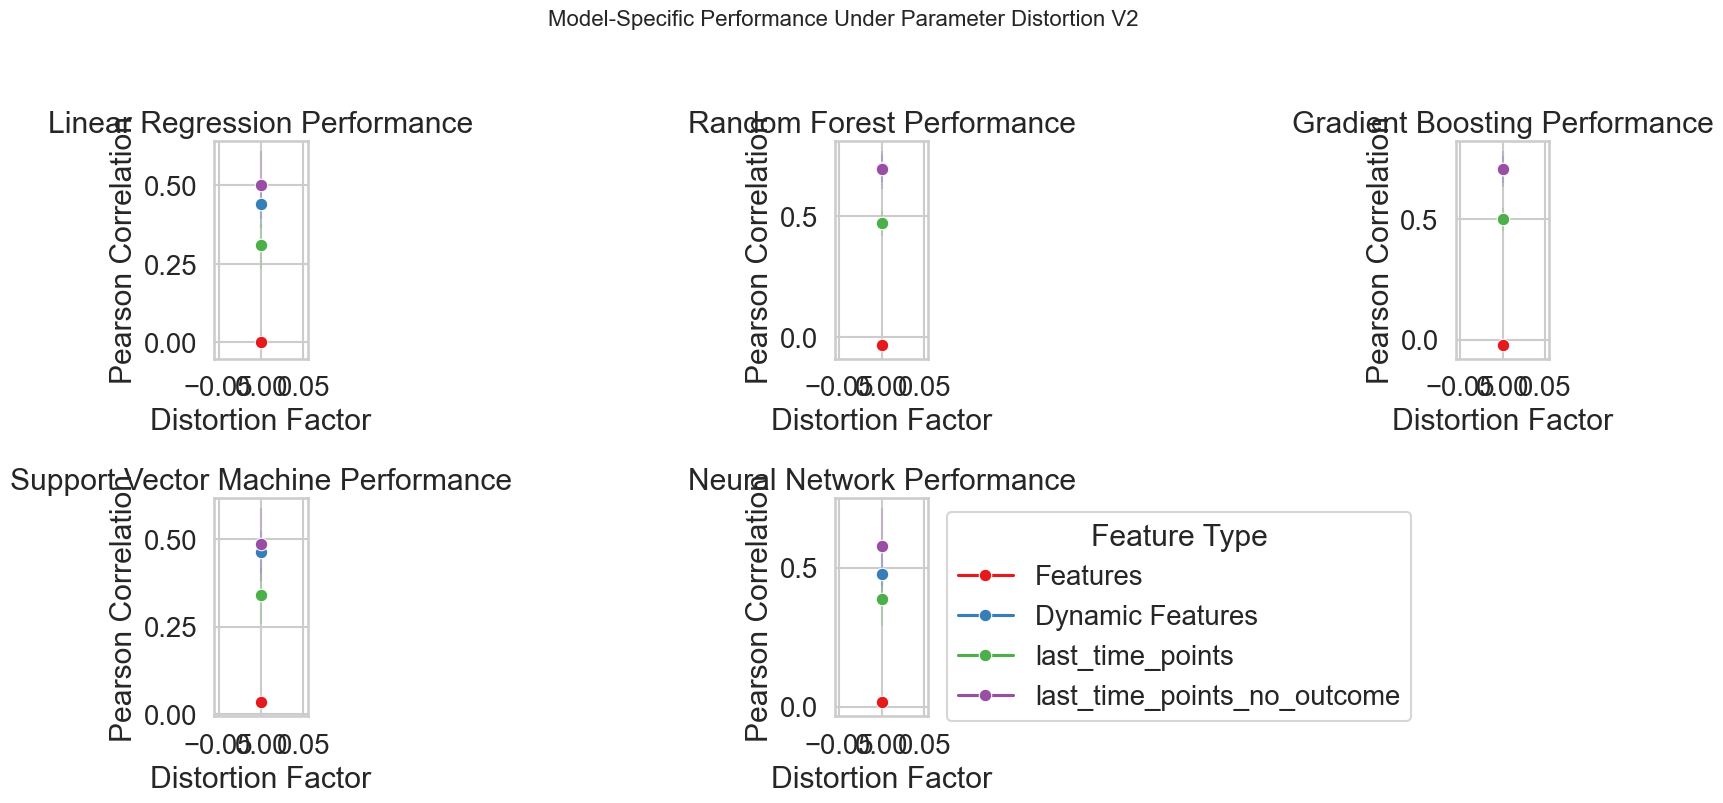

In [54]:
def plot_model_specific_analysis(data_df: pd.DataFrame, metric: str = "Pearson Correlation"):
    """
    Plot model-specific performance analysis.
    
    Adapted from robustness notebooks multi-panel plots.
    """
    if data_df.empty:
        print("❌ No data to plot")
        return
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    # Get unique models
    models = data_df["Model"].unique()
    n_models = len(models)
    
    # Calculate grid dimensions
    n_cols = min(3, n_models)  # Max 3 columns
    n_rows = (n_models + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    fig.suptitle(f"Model-Specific Performance Under {EXPERIMENT_TYPE.replace('-', ' ').title()}", 
                 fontsize=16, y=1.02)
    
    # Flatten axes array for easy iteration
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Create plot for each model
    for i, model in enumerate(models):
        ax = axes[i]
        model_data = data_df[data_df["Model"] == model]
        
        # Use cleaned feature types if available
        if 'feature_type' in model_data.columns:
            hue_col = 'feature_type'
            legend_title = 'Feature Type'
        else:
            hue_col = 'Feature Data'
            legend_title = 'Feature Data Type'
        
        sns.lineplot(data=model_data, x=perturbation_col, y=metric,
                     hue=hue_col, palette="Set1", marker="o", ax=ax)
        
        ax.set_title(f"{model} Performance")
        ax.set_xlabel(perturbation_col.replace('_', ' ').title())
        ax.set_ylabel(metric)
        
        # Remove legend to avoid clutter
        ax.legend().remove()
    
    # Add legend to last plot
    if n_models > 0:
        if 'feature_type' in data_df.columns:
            legend_title = 'Feature Type'
        else:
            legend_title = 'Feature Data'
        
        axes[min(n_models - 1, len(axes) - 1)].legend(title=legend_title, 
                                                      bbox_to_anchor=(1.05, 1), 
                                                      loc="upper left")
    
    # Hide any unused subplots
    for i in range(len(models), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Display the plot
if not data_df.empty:
    print("📈 Plot 5: Model-Specific Analysis")
    plot_model_specific_analysis(data_df, metric="Pearson Correlation")
else:
    print("⚠️ No data available for visualization")

### 6. R2 Score vs Perturbation Level

📈 Plot 6: R2 Score vs Perturbation Level


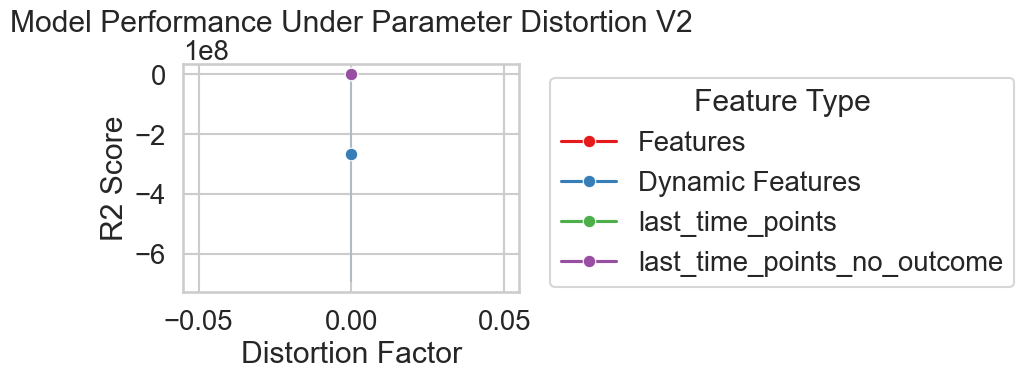

In [55]:
# Reuse plot_performance_vs_perturbation function but with R2 Score metric
if not data_df.empty and "R2 Score" in data_df.columns:
    print("📈 Plot 6: R2 Score vs Perturbation Level")
    plot_performance_vs_perturbation(data_df, metric="R2 Score")
else:
    print("⚠️ No R2 Score data available for visualization")

### 7. Mean Squared Error vs Perturbation Level

📈 Plot 7: Mean Squared Error vs Perturbation Level


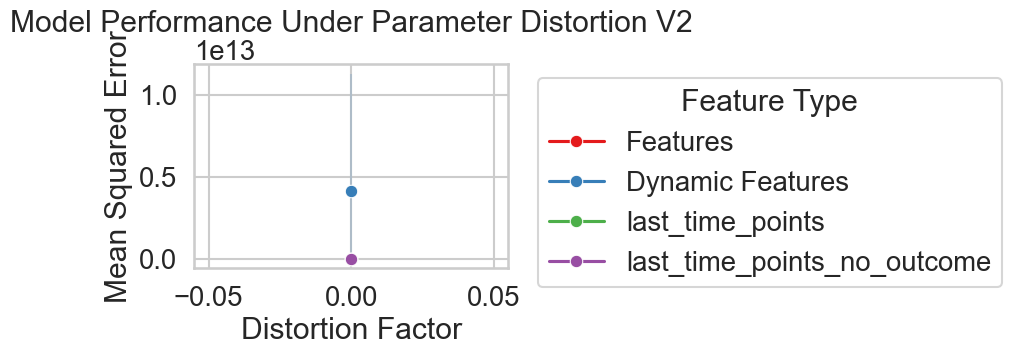

In [56]:
# Reuse plot_performance_vs_perturbation function but with Mean Squared Error metric
if not data_df.empty and "Mean Squared Error" in data_df.columns:
    print("📈 Plot 7: Mean Squared Error vs Perturbation Level")
    plot_performance_vs_perturbation(data_df, metric="Mean Squared Error")
else:
    print("⚠️ No Mean Squared Error data available for visualization")

## Statistical Analysis

Adapted from robustness notebooks statistical analysis sections

In [57]:
def perform_statistical_analysis(data_df: pd.DataFrame):
    """
    Perform statistical analysis on the results.
    
    Adapted from robustness notebooks statistical analysis.
    """
    if data_df.empty:
        print("❌ No data for statistical analysis")
        return
    
    print("📊 Statistical Analysis")
    print("=" * 50)
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    # 1. Summary statistics by perturbation level
    print("\n1. Summary Statistics by Perturbation Level:")
    if perturbation_col in data_df.columns:
        stats_summary = data_df.groupby(perturbation_col).agg({
            'Pearson Correlation': ['mean', 'std', 'min', 'max'],
            'R2 Score': ['mean', 'std'],
            'Mean Squared Error': ['mean', 'std']
        }).round(3)
        
        print(stats_summary)
    else:
        print("   No perturbation levels available")
    
    # 2. Model performance comparison
    print("\n2. Model Performance (Average Pearson Correlation):")
    model_stats = data_df.groupby(['Model', perturbation_col])['Pearson Correlation'].mean().unstack()
    print(model_stats.round(3))
    
    # 3. Calculate performance degradation
    print("\n3. Performance Degradation Analysis:")
    if perturbation_col in data_df.columns:
        # Find baseline (lowest perturbation level)
        perturbation_levels = sorted(data_df[perturbation_col].unique())
        if perturbation_levels:
            baseline_level = min(perturbation_levels)
            baseline_data = data_df[data_df[perturbation_col] == baseline_level]
            perturbed_data = data_df[data_df[perturbation_col] > baseline_level]
            
            if not baseline_data.empty:
                baseline_mean = baseline_data['Pearson Correlation'].mean()
                print(f"   Baseline performance ({perturbation_col} = {baseline_level}): {baseline_mean:.3f}")
                
                for level in perturbation_levels[1:]:  # Skip baseline
                    level_data = data_df[data_df[perturbation_col] == level]
                    if not level_data.empty:
                        level_mean = level_data['Pearson Correlation'].mean()
                        degradation = baseline_mean - level_mean
                        degradation_pct = (degradation / baseline_mean) * 100 if baseline_mean != 0 else 0
                        print(f"   {perturbation_col} {level}: {level_mean:.3f} "
                              f"(degradation: {degradation:.3f}, {degradation_pct:.1f}%)")
    
    # 4. Statistical significance testing between feature data types
    print("\n4. Feature Data Type Comparison (Pearson Correlation):")
    feature_types = data_df['Feature Data'].unique()
    if len(feature_types) > 1:
        from scipy import stats
        
        for i, type1 in enumerate(feature_types):
            for type2 in feature_types[i+1:]:
                data1 = data_df[data_df['Feature Data'] == type1]['Pearson Correlation']
                data2 = data_df[data_df['Feature Data'] == type2]['Pearson Correlation']
                if len(data1) > 1 and len(data2) > 1:
                    t_stat, p_value = stats.ttest_ind(data1, data2)
                    print(f"   {type1} vs {type2}: t={t_stat:.3f}, p={p_value:.4f}")
    else:
        print("   Only one feature data type available")
    
    print("\n" + "=" * 50)

## Run Statistical Analysis

In [58]:
if not data_df.empty:
    perform_statistical_analysis(data_df)
else:
    print("⚠️ No data available for statistical analysis")

📊 Statistical Analysis

1. Summary Statistics by Perturbation Level:
                  Pearson Correlation                           R2 Score  \
                                 mean    std    min    max          mean   
Distortion Factor                                                          
0.0                             0.423  0.334 -0.121  0.895 -1.060950e+08   

                                Mean Squared Error                
                            std               mean           std  
Distortion Factor                                                 
0.0                2.237971e+09       1.643350e+12  3.477548e+13  

2. Model Performance (Average Pearson Correlation):
Distortion Factor         0.0
Model                        
Gradient Boosting       0.521
Linear Regression       0.340
Neural Network          0.388
Random Forest           0.508
Support Vector Machine  0.358

3. Performance Degradation Analysis:
   Baseline performance (Distortion Factor = 0.0): 0.423


## Performance Metrics Summary

In [59]:
def generate_performance_summary(data_df: pd.DataFrame):
    """
    Generate comprehensive performance summary table.
    
    Adapted from robustness notebooks performance metrics summary.
    """
    if data_df.empty:
        print("❌ No data for performance summary")
        return
    
    # Determine perturbation column name
    perturbation_col = PERTURBATION_MAPPING.get(EXPERIMENT_TYPE, "perturbation_level")
    if perturbation_col not in data_df.columns:
        perturbation_col = "perturbation_level"
    
    print("📋 Performance Summary Table:")
    print("=" * 70)
    
    if perturbation_col in data_df.columns:
        # Group by perturbation level, model, and feature data
        performance_summary = data_df.groupby([perturbation_col, 'Model', 'Feature Data']).agg({
            'Pearson Correlation': ['mean', 'std', 'count'],
            'R2 Score': ['mean', 'std'],
            'Mean Squared Error': ['mean', 'std']
        }).round(3)
        
        print(performance_summary)
    else:
        # Group by model and feature data only
        performance_summary = data_df.groupby(['Model', 'Feature Data']).agg({
            'Pearson Correlation': ['mean', 'std', 'count'],
            'R2 Score': ['mean', 'std'],
            'Mean Squared Error': ['mean', 'std']
        }).round(3)
        
        print(performance_summary)
    
    print("\n" + "=" * 70)

## Generate Performance Summary

In [60]:
if not data_df.empty:
    generate_performance_summary(data_df)
else:
    print("⚠️ No data available for performance summary")

📋 Performance Summary Table:
                                                                         Pearson Correlation  \
                                                                                        mean   
Distortion Factor Model                  Feature Data                                          
0.0               Gradient Boosting      dynamic_features_0                            0.880   
                                         dynamic_features_0.1                          0.838   
                                         dynamic_features_0.5                          0.406   
                                         dynamic_features_no_outcome_0                 0.880   
                                         dynamic_features_no_outcome_0.1               0.839   
...                                                                                      ...   
                  Support Vector Machine last_time_points_0.1                          0.494   
           